# Cortical network model simulations for hFUS paper

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# External imports
import os
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Internal imports
from network import NeuralNetwork
from logger import logger
from utils import *

# Record notebook start time
t0 = time.perf_counter()

# Set up figures directory and initialize figures dictionary
figs_dir = 'figures/'
figs = {}

### Input parameters

In [4]:
# Drive parameters
noise_amp = 2e-3  # noise amplitude (mA/cm2)

# Stimulus parameters
start = 50 # start time (ms)
dur = 150  # duration (ms)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep
Isppa_range_dense = sqrtspace(0, Imax, 30)  # dense range of intensities to sweep

# Simulation parameters
tstop = 350  # default simulation duration (ms)
nreps = 50  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'noise': [
        f'amplitude = {noise_amp:.3f} mA/cm2'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 25/10/2024 15:14:44: Input parameters:
   - noise:
       - amplitude = 0.002 mA/cm2
   - stimulus:
       - start = 50 ms
       - duration = 150 ms
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 350 ms
       - number of repetitions (for sweeps) = 50


### Initialize single-node model

In [5]:
# Initialize single-node model with temperature-dependent components
nnodes = 1
model = NeuralNetwork(
    nnodes,
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=NeuralNetwork.gKT_default,  # S/cm2
    a=1e-4, 
    b=0.5,
    synweight=90e-6, # synaptic weight (S/cm2)
)

# Set stimulus start and duration
model.start = start
model.dur = dur

# Set simulation duration
model.tstop = tstop

 25/10/2024 15:14:44: NeuralNetwork(1): created 1 node
 25/10/2024 15:14:44: NeuralNetwork(1): setting Q10_rates = 3 on node 0
 25/10/2024 15:14:44: NeuralNetwork(1): setting Q10_gNa = 1.4 on node 0
 25/10/2024 15:14:44: NeuralNetwork(1): setting Q10_gKd = 4.75 on node 0
 25/10/2024 15:14:44: NeuralNetwork(1): setting gKT = 4.898648648648648e-06 on node 0
 25/10/2024 15:14:44: NeuralNetwork(1): setting a = 0.0001 on node 0
 25/10/2024 15:14:44: NeuralNetwork(1): setting b = 0.5 on node 0
 25/10/2024 15:14:44: NeuralNetwork(1): initialized


### Find spiking threshold without stochastic noise

 25/10/2024 15:14:44: NeuralNetwork(1): finding response thresold intensity within [0, 500.0] W/cm2 interval
 25/10/2024 15:14:44: NeuralNetwork(1): setting 150.00 ms stimulus with amplitude 27.22 W/cm2 on 100.0% of nodes
 25/10/2024 15:14:44: NeuralNetwork(1): simulating for 350.00 ms
 25/10/2024 15:14:44: Spiking threshold: 27.22 W/cm2 <-> 0.52 uA/cm2


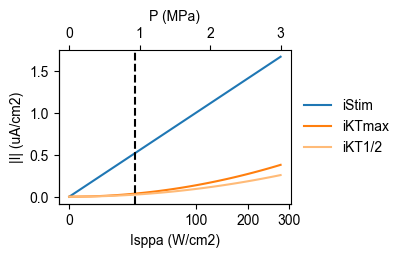

In [6]:
# Find spiking threshold and corresponding current amplitude
Ithr = model.find_spiking_threshold()
model.set_stim(Ithr)
data = model.simulate()
iStimthr = data['iStim'].abs().max()
logger.info(f'Spiking threshold: {Ithr:.2f} W/cm2 <-> {iStimthr * 1e3:.2f} uA/cm2')

# Plot EI imbalance over intensity range, and mark spiking threshold
figs['EI imbalance'] = model.plot_EI_imbalance(Imax, xscale='sqrt')
figs['EI imbalance'].axes[0].axvline(Ithr, color='k', linestyle='--');

### Run detailed simulations in sub-threshold, threshold and supra-threshold regimes, with noise

 25/10/2024 16:31:04: NeuralNetwork(1): setting 150.00 ms stimulus with amplitude 21.78 W/cm2 on 100.0% of nodes
 25/10/2024 16:31:05: NeuralNetwork(1): simulating for 350.00 ms
 25/10/2024 16:31:05: NeuralNetwork(1): setting 150.00 ms stimulus with amplitude 32.67 W/cm2 on 100.0% of nodes
 25/10/2024 16:31:05: NeuralNetwork(1): simulating for 350.00 ms
 25/10/2024 16:31:05: NeuralNetwork(1): setting 150.00 ms stimulus with amplitude 108.89 W/cm2 on 100.0% of nodes
 25/10/2024 16:31:05: NeuralNetwork(1): simulating for 350.00 ms
 25/10/2024 16:31:05: NeuralNetwork(1): plotting results


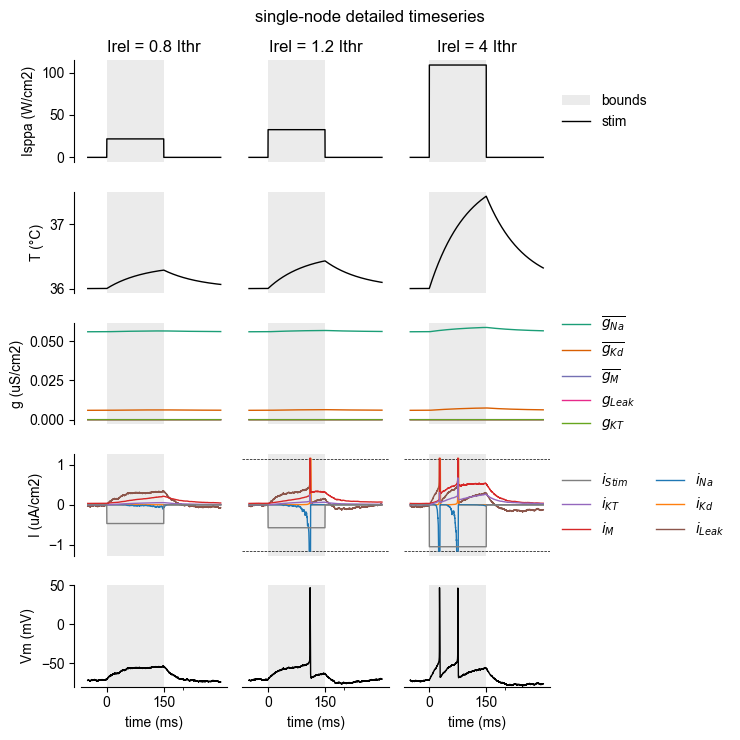

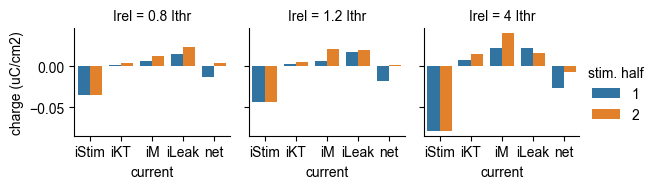

In [19]:
# Set sub- and supra-threshold amplitudes
rel_Isppas = [0.8, 1.2, 4]

# Add stochastic noise
model.noise_amp = noise_amp  # mA/cm2

# Plot simulation results at various sub, threshold and supra-threshold amplitudes
data = {}
for rel_Isppa in rel_Isppas:
    Isppa = rel_Isppa * Ithr
    model.set_stim(Isppa)
    data[f'{rel_Isppa} Ithr'] = model.simulate()
data = pd.concat(data, axis=0, names=['Irel'])

title = f'single-node detailed timeseries'
figs[title] = model.plot_results(
    data, 
    exclude=[
        # 'T',
        # 'conductances', 
    ], 
    clip_currents=True,
    gmode='abs',
)
figs[title].suptitle(title)

# Compare injected charges by each current in first and second half of stimulus
charges = model.compute_charge_by_stimhalf(data).drop(['iNa', 'iKd'], axis=1)
charges['net'] = charges.sum(axis=1)
qkey = 'charge (uC/cm2)'
g = sns.catplot(
    height=2,
    data=charges.stack().rename(qkey).reset_index(),
    kind='bar',
    x='current',
    y=qkey,
    hue='stim. half',
    col='Irel',
)
figs['single node charge'] = g.figure

### Extend to 3-nodes

 23/10/2024 12:39:07: NeuralNetwork(3): created 3 nodes
 23/10/2024 12:39:07: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 23/10/2024 12:39:07: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 23/10/2024 12:39:07: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 23/10/2024 12:39:07: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 23/10/2024 12:39:07: NeuralNetwork(3): setting a = 0.0001 on all nodes
 23/10/2024 12:39:07: NeuralNetwork(3): setting b = 0.5 on all nodes
 23/10/2024 12:39:07: NeuralNetwork(3): initialized
 23/10/2024 12:39:07: NeuralNetwork(3): connecting 100.0% (6/6) of candidate node pairs
 23/10/2024 12:39:07: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 32.67 W/cm2 on 33.3% of nodes
 23/10/2024 12:39:07: NeuralNetwork(3): simulating for 350.00 ms
 23/10/2024 12:39:07: NeuralNetwork(3): plotting results
 23/10/2024 12:39:08: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 32.67 W/cm2 on 100.0% of nodes
 

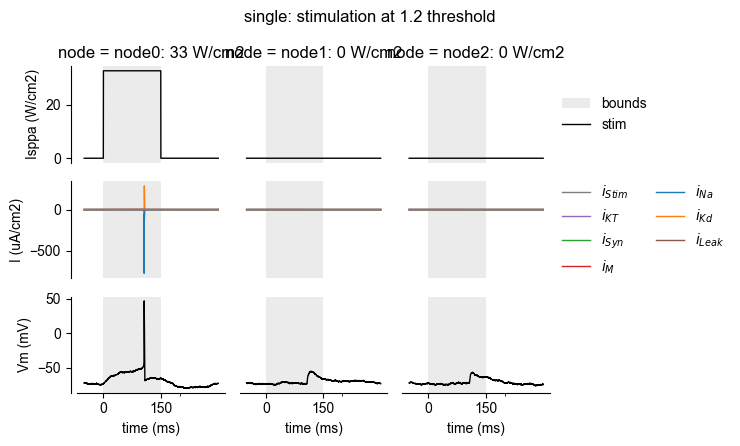

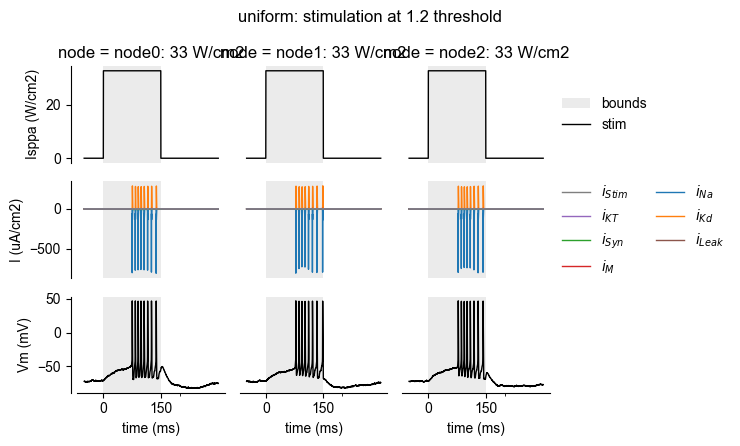

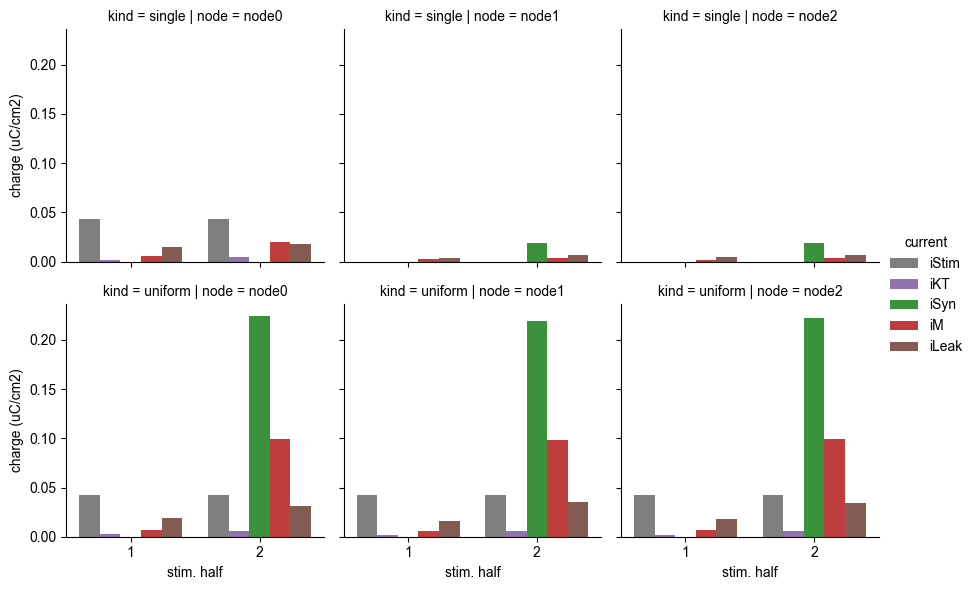

In [17]:
# Create 3-nodes network
model3 = model.copy(nnodes=3)
model3.connect_nodes(weight=90e-6)  # synaptic weight (S/cm2))

# Plot simulation results at various sub, threshold and supra-threshold amplitudes 
datacomp = {}
for kind, xvec in model3.get_stimdists().items():
    rel_Isppa = 1.2
    Isppa = rel_Isppa * Ithr
    model3.set_stim(Isppa * xvec)
    data = model3.simulate()
    title = f'{kind}: stimulation at {rel_Isppa} threshold'
    figs[title] = model3.plot_results(
        data, 
        exclude=[
            'T',
            'conductances', 
            # 'currents',
        ],
        clip_currents=False, 
    )
    figs[title].suptitle(title)
    datacomp[kind] = data

# Compare injected charges by each current in first and second half of stimulus
datacomp = pd.concat(datacomp, axis=0, names=['kind'])
charges = model3.compute_charge_by_stimhalf(datacomp).drop(['iNa', 'iKd'], axis=1)
g = sns.catplot(
    data=charges.abs().stack().rename(qkey).reset_index(),
    kind='bar',
    x='stim. half',
    hue='current',
    y=qkey,
    col='node',
    row='kind',
    height=3,
    palette=model.CURRENTS_CMAP
)
figs['3nodes charge comp'] = g.figure

### Evoked activity across stimulus amplitude/intensity range

 22/10/2024 18:50:53: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 32.67 W/cm2 on 100.0% of nodes
 22/10/2024 18:50:53: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [06:22<00:00, 12.76s/it]


 22/10/2024 19:02:35: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [06:42<00:00, 13.40s/it]


Text(0.5, 1.02, 'accumulated charge across amplitude range (50 reps)')

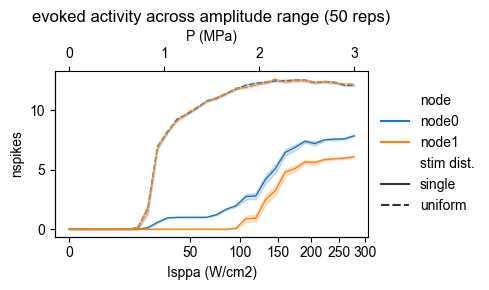

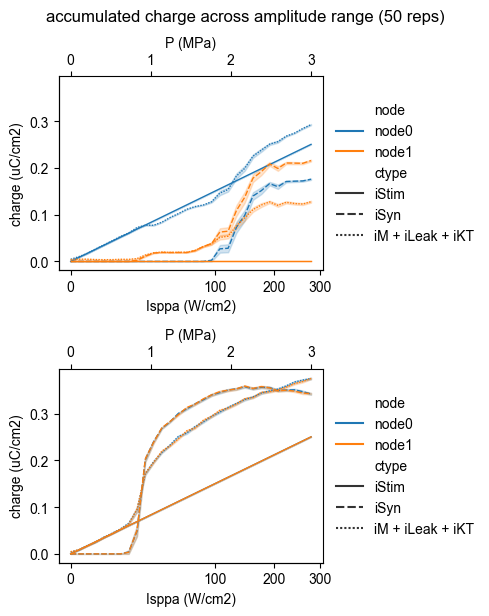

In [8]:
# Set stimulus
model3.set_stim(Isppa, start=start, dur=dur)

# Run comparative simulations across Isppa range and extract spike counts
mdata = model3.run_comparative_sweep(
    Isppa_range_dense, 
    ['nspikes', 'charge'],
    nreps=nreps,
    # sigmaI=0.1
)
mdata = mdata.loc[pd.IndexSlice[:, :, :, ['node0', 'node1']], :]

# Plot spike count across Isppa range for each stim dist
nspikes = mdata['nspikes']['nspikes']
figs['nspikes_vs_pressure'], ax = plt.subplots(figsize=(5, 3))
ax.set_title(f'evoked activity across amplitude range ({nreps} reps)', fontsize=12)
model.plot_sweep_results(
    nspikes, 
    ax=ax, 
    legend=True, 
    marker=None, 
    xscale='sqrt',
    estimator='mean',
)
# Adjust figure layout
figs['nspikes_vs_pressure'].tight_layout()

# Plot charge by type across Isppa range for each stim dist
charges = mdata['charge']
charges.columns.name = 'ctype'
hypkeys = ['iM', 'iLeak', 'iKT']
hypkey = ' + '.join(hypkeys)
charges[hypkey] = charges[hypkeys].sum(axis=1)
abscharges = charges.abs()[['iStim', 'iSyn', hypkey]].stack().rename('charge (uC/cm2)')
figs['charge_vs_pressure'], axes = plt.subplots(2, 1, figsize=(5, 6))
gby = 'stim dist.'
for (k, v), ax in zip(abscharges.groupby(gby), axes):
    fig = model.plot_sweep_results(
        v.droplevel(gby), 
        ax=ax,
        xscale='sqrt', 
        estimator='mean',
        legend=True,
        marker=None,
    )
ylims = (min(ax.get_ylim()[0] for ax in axes), max(ax.get_ylim()[1] for ax in axes))
for ax in axes:
    ax.set_ylim(ylims)
figs['charge_vs_pressure'].tight_layout()
figs['charge_vs_pressure'].suptitle(
    f'accumulated charge across amplitude range ({nreps} reps)', fontsize=12, y=1.02)

Text(0.5, 1.02, 'accumulated charge across amplitude range (50 reps)')

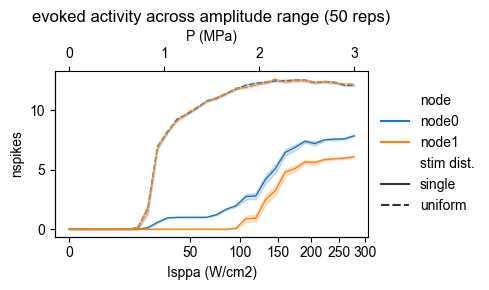

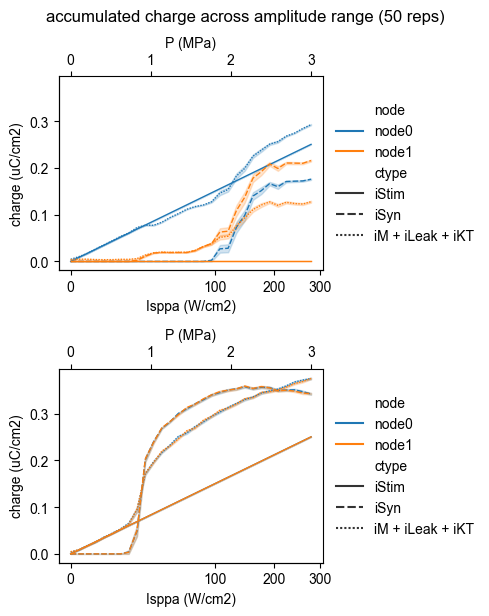

In [18]:
# Plot spike count across Isppa range for each stim dist
nspikes = mdata['nspikes']['nspikes']
figs['nspikes_vs_pressure'], ax = plt.subplots(figsize=(5, 3))
ax.set_title(f'evoked activity across amplitude range ({nreps} reps)', fontsize=12)
model.plot_sweep_results(
    nspikes, 
    ax=ax, 
    legend=True, 
    marker=None, 
    xscale='sqrt',
    estimator='mean',
    # errorbar='sd'
    # errorbar=('ci', 95),
)
# Adjust figure layout
figs['nspikes_vs_pressure'].tight_layout()

# Plot charge by type across Isppa range for each stim dist
charges = mdata['charge']
charges.columns.name = 'ctype'
hypkeys = ['iM', 'iLeak', 'iKT']
hypkey = ' + '.join(hypkeys)
charges[hypkey] = charges[hypkeys].sum(axis=1)
abscharges = charges.abs()[['iStim', 'iSyn', hypkey]].stack().rename('charge (uC/cm2)')
figs['charge_vs_pressure'], axes = plt.subplots(2, 1, figsize=(5, 6))
gby = 'stim dist.'
for (k, v), ax in zip(abscharges.groupby(gby), axes):
    fig = model.plot_sweep_results(
        v.droplevel(gby), 
        ax=ax,
        xscale='sqrt', 
        estimator='mean',
        # errorbar='sd',
        # errorbar=('ci', 95),
        legend=True,
        marker=None,
    )
ylims = (min(ax.get_ylim()[0] for ax in axes), max(ax.get_ylim()[1] for ax in axes))
for ax in axes:
    ax.set_ylim(ylims)
figs['charge_vs_pressure'].tight_layout()
figs['charge_vs_pressure'].suptitle(
    f'accumulated charge across amplitude range ({nreps} reps)', fontsize=12, y=1.02)

## Save figures

In [14]:
# Check that figures directory exists
figsdir = os.path.abspath(figs_dir)
if not os.path.isdir(figsdir):
    raise ValueError(f'Figures directory "{figsdir}" does not exist')

# Save figures in directory
save_figs_book(figsdir, figs)

 25/10/2024 15:56:12: saving figures in /Users/tlemaire/Documents/code/fusnetwork/figures/2024.10.25/figs.pdf:


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


## Log completion

In [10]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 22/10/2024 19:15:25: notebook completed in 0:24:39.812404
